** A simulation of Thousand Network!! **

 ![network_example](figures/network_example.png)
 _by @KeldLundgaard_ 

Dear Thousand Network!

My name is Keld, I am from Denmark, and I have been living in the Bay Area for the last ~4 years. I came over for my PhD program in physics, and have been working on simulating chemistry to create novel materials that can make the world more sustainable.

Professionally, I consider myself to be a scientist/engineer/entrepreneur. On the entrepreneurial front, I have, amoung other things, founded and lead the organization Gate to Create (G2C), which connects local student-driven entrepreneurship organizations across Denmark, www.gatetocreate.dk. I am very pround to say that the organization is still operating today, and plays a small, but important role, in nurturing the entrepreneurial ecosystem in Denmark. 

Since coming to the bay, I have kept an interest in organizational structures, and worked on a couple of projects with the aim of creating better decision tools for organizations and ultimatively help creating more efficient societies, i.e. a better democracy.

For the WOW project, I thought it would be interesting to try to combine my experiences with simulations from my academic work and my passion for organizational design by creating a simulation of ThousandNetwork -- that's right we are going to model ThousandNetwork, exiting huh! 

One of the things that have made me really excited about ThousandNetwork is the sense of family and trust that I have felt from the people in the network.  This especially comes through in stories of the hospitality members experience across the world when they travel for work or pleasure. This must mean that there is an incredible trust in the network, which might be because the network is so well connected!

How can that be? What is it that makes the network so trusting, or so connected. I only know ThousandNetwork from the outside, although I have been going to open events with people from the network for the last 5 years! However, I wonder if a simulation of the organization might offer an answer to this question, and perhaps offer suggestions to some of the challenges the organization will face in the future.

My simulation will be based on what I think are the fundamental building blocks, and it will therefore be limited by my knowledge and assumptions, so you can say that it will also be a test of how well I understand the operation of the network! You could ask, what interest do we have in as model that is only approximative to the reality. However, as I proposed before, a simulation can give us a picture into the future, and we can therefore explore different paths of the organization given how we let it operate. Interesting questions could be:
 - How will the age distribution change over time
 - How will that be affected by a maximum age on members
 - What happens if you started to take in a lot more members 
 - How connected is the network and how to affect the connectivity
 
These are some of the questions that I will try to provide answers to.

I think it would be most illustrative to build up the simulation step by step. This will illustrations how the different parts work. Afterwards, I will try to envision different futures for the network, and lastly invite you to treak the model yourself and try simulating the network yourself :)

Enjoy
![Keld](figures/keld_profile.jpg)

In [1]:
%pylab inline
from IPython.display import Image
pylab.rcParams['figure.figsize'] = (8, 6)

Populating the interactive namespace from numpy and matplotlib


I will here mix text and code. You do not need to read or understand the codeblocks (I have tried to make them as easily read as possible though). Instead, feel free to only read the text blurbs, and view the output of the code block.

This is the static version of the document.

I have also made [a live instance of this document available here](https://ec2-54-67-55-17.us-west-1.compute.amazonaws.com:8889/notebooks/Thousand%20Network%20simulation.ipynb)! 
Password: thousandnetwork. Here you to see what happen if you change any of the options and run the simulation. Beware the last simulation takes quite a long time to run! [see this guide for how to use a jupyter document like this](http://nbviewer.jupyter.org/github/ipython/ipython/blob/1.x/examples/notebooks/Part%201%20-%20Running%20Code.ipynb).

In [3]:
# First we load some global variables 

# I'll use the igraph library for the graph manipulation 
# through python-igraph api 
import igraph as ig

# These libraries were created for this project, and are shared on GitHub
# https://github.com/keldLundgaard/ThousandNetwork_simulation
from simulation_code import run_simulation, run_simulation_cached
from simulation_data import data
import simulation_stat_plots as ssp
import os

folder = 'ThousandNetwork_application_figures'
if not os.path.exists(folder):
    os.mkdir(folder)

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Alright. Let's begin. 

First, let's make a very simple network.  

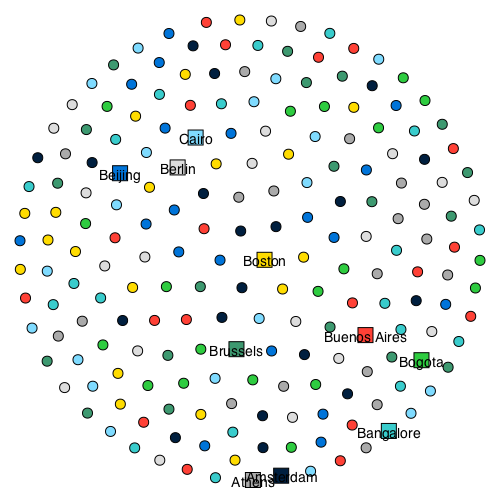

In [4]:
name = 'no_events'
TN_configs = {
    'hub_starting_members_avg': 20,
    'hub_cities': data['ThousandNetwork_cities'][:10]}

g, _ = run_simulation(TN_configs)

ssp.show_graph(g, folder+'/'+name)
Image(folder+'/'+name+'.png')

In the above figure, each shape illustrates a member in the network. We have 10 cities, with each 20 members. Each city has a color associated with it -- e.g. blue is for Beijing. For each city we'll promote an ambassador, and make him/her a square! The city name will follow the ambassador of the city. 

Each member has a starting age, which we take from a normal distribution with mean 24 and standard deviation 2. Let's see how that comes out...

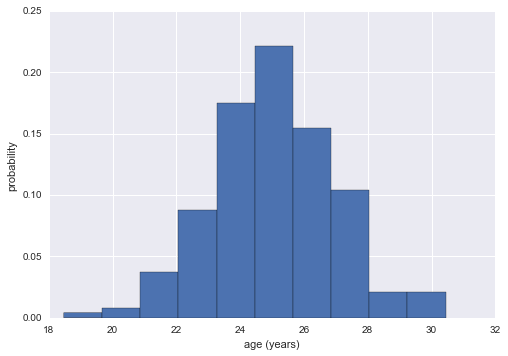

In [5]:
plt.hist(g.vs['age'], normed=True)
plt.xlabel('age (years)')
plt.ylabel('probability')
plt.savefig(folder+'/age_initial.pdf')

Looks reasonably! Not much is happening here though. 

Let's make things a bit more interesting by introducing hub events at each city. In each hub, the ambassador can create a number of yearly events, where some of the hub's members can participate and interact with each other. Say we'll have 5 local events, with 10 participants each (the ambassador will always be amoung them). At each event, there will be 5 times as many interactions as participants, meaning that each participant will have 10 interactions on average.  

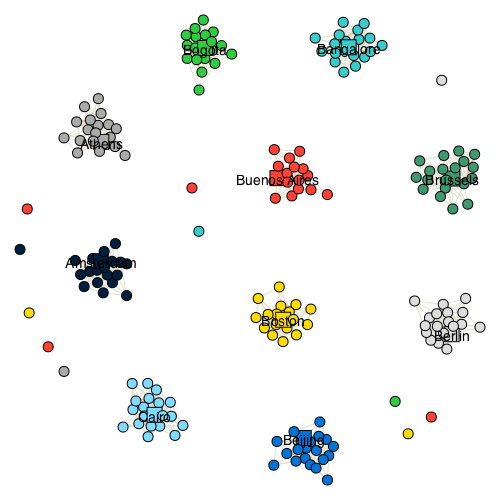

In [6]:
TN_configs.update({
    'yearly_local_events': 5,
    'local_event_participants': 10,
    'local_event_avg_new_link_per_participant': 5,
    'simulation_years': 1})

g, _ = run_simulation(TN_configs)
ssp.show_graph(g, folder+'/local_events')
Image(folder+'/local_events.png')

We now have a cluster for each city, and if you look closely, you can also see that there are connections between the members. These lines shows who have interacted with each other. 
However, some of the members are all by themselves still. These members haven't participated in any events yet, or perhaps did not make any interactions at the events they participated in (Sad I know)! 

Let's next add an element of time in the simulation. For simplicity, I'll let the simulation operate in years. Each year, we'll have a number of events, like the local events that we saw before. However, we'll also have to take into account of new members and some churn. 

For new members, I'll have each hub take in a number of new members as a proportion of the current members. In a startup, the usual organization growth that is strived for is a doubling every year. Back in the Sandbox Network days, that might be the growth rate. Now, I would however assume that the growth has leveling out, so let's put the growth rate at 25%.

For churn, I'll let the chance that a member is leaving depend on how connected the member is, so less connected members will more likely leave. Let's for simplicity say that it is the amount of connections the person has had over all time: 

    chance of leaving = [ 75% / (interations+1) ] + 2%,

where I have added a 2% base rate independent of the number of interactions. 

Let's see how that pans out when we run the simulation for 10 years

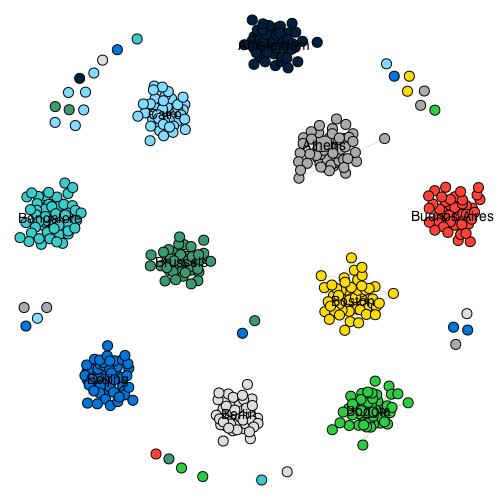

In [7]:
name = 'new_members_and_churn'

TN_configs.update({
    'new_member_ratio': 0.25,
    'base_churn': 0.02,  # base rate that person will leave org
    'churn_no_degree_rate': 0.75,
    'degree_count_power': 1.0,
    'simulation_years': 10})

g, g_states = run_simulation(TN_configs)
ssp.show_graph(g, folder+'/'+name)
Image(folder+'/'+name+'.png')

It's hard to count the number of members, and the graph only shows the end result after 10 iterations of the simulatino. Let's therefore see how the number of members evolve over time by plotting a graph:

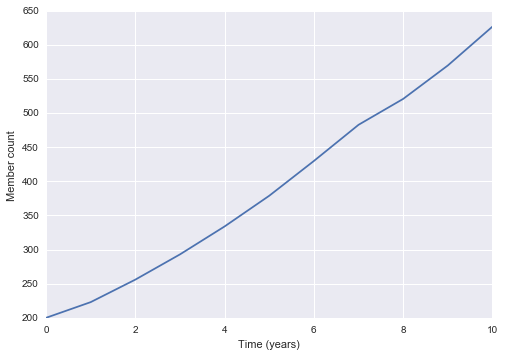

In [8]:
ssp.plot_members_over_time(g_states, filename=folder+'/'+name+'.pdf')

Interesting. Number of members keeps increasing quite steadily from 200 to ~650 over the 10 years. I think that's a bit too drastic, so i'll make the following 

chance of leaving = [ 75% / square root(interations+1) ] + 2%,

where we now take the square root of the interactions

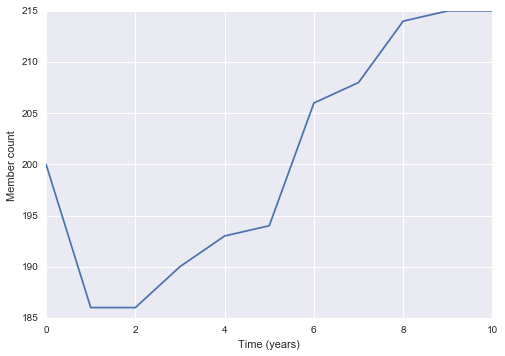

In [9]:
name = 'new_members_and_churn_2'

TN_configs.update({
    'degree_count_power': 0.5,
})
g, g_states = run_simulation(TN_configs)
ssp.show_graph(g, folder+'/'+name)
ssp.plot_members_over_time(g_states, filename=folder+'/'+name+'.pdf')

We see a dip it the beginning, and then an increase in members as time goes on. This is probably because our members in the simulation start out with no connections, so they'll tend to leave a lot more the first couple of years while they get to know each other. 

**ThousandNetwork connects internationally **

The network simulation is completely missing the international aspect of ThousandNetwork. Let's fix that. 

First it's members tend to hop between the cities, so let's add some city hopping. Say, 5% change that a member will move to another city each year. How will the network look after 5 years:

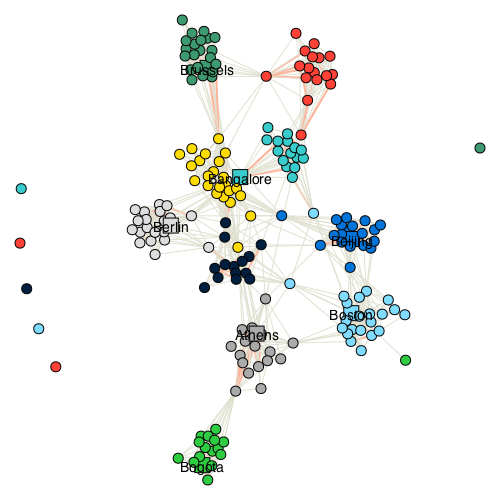

In [10]:
name = 'city_hopping'

TN_configs.update({
    'city_hopping_propability': 0.05, 
    'simulation_years': 5})
g, g_states = run_simulation(TN_configs)
ssp.show_graph(g, folder+'/'+name)
Image(folder+'/'+name+'.png')

Yep, we have international connections now. We see that a number of members have changed city by still having connections to their former city. The orange lines the members shows who have had 5 interactions or more. 

Members, however, also meet at the global retreat, which I hope to attent some day. Let's add such an event as well. We'll again give preference to the ambassadors of the cities, and fill out the rest of the slots with members of the hubs. 

With 10 cities, I will let the global event have 100 participants and an average of 40 interactions per participant! 

NB: I will delete members with no connections from now on when the simulation ends.

Here is how that goes down. 

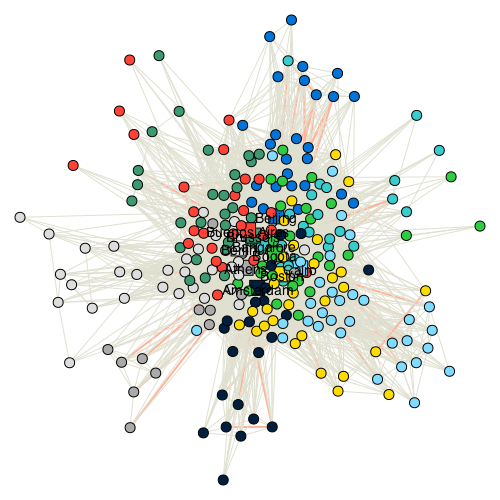

In [11]:
name = 'with_global_event'

TN_configs.update({
    'yearly_global_retreats': 1,
    'global_retreat_goers': 100,
    'global_retreat_link_multiplier': 20,
    })
g, g_states = run_simulation(TN_configs)
ssp.plot_graph(
    g, folder+'/'+name+'.png', 
    delete_zero_connections=1)
Image(folder+'/'+name+'.png')

Now we have a truely globally connected network :) 

** Electing new ambassadors **

Currently, the ambassadors are fixed for the entire duration of the simulation. Let's instead make it so that each hub will elect a new year ambassador each year. To choose the next ambassador, I'll use the square root to the number of connections for each member to determine the change that a member will be elected, so that the more connections the higher chance that you will become the next ambassador (A former ambassador can be elected again).

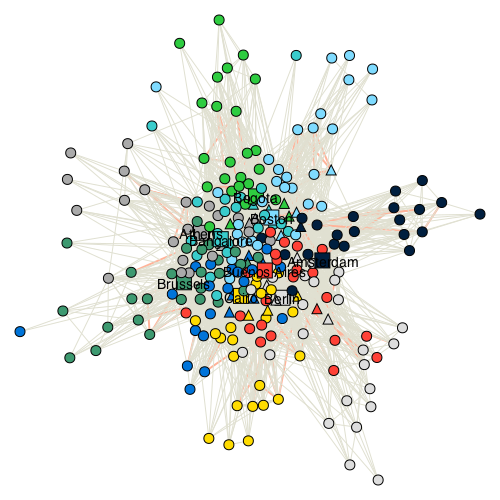

In [12]:
name = 'with_new_ambassador_election'

TN_configs.update({
    'promote_new_ambassador_yearly': True,
})
g, g_states = run_simulation(TN_configs)
ssp.plot_graph(
    g, folder+'/'+name+'.png', 
    delete_zero_connections=1)
Image(folder+'/'+name+'.png')

In the above figure, the triangles show who have been an ambassador at any previous time. We can see that the ambassadors tend to be clustered in the middle as they are the mostly connected members.

Let's compare connection distributions of the normal members and members who are or have been ambassaders. 

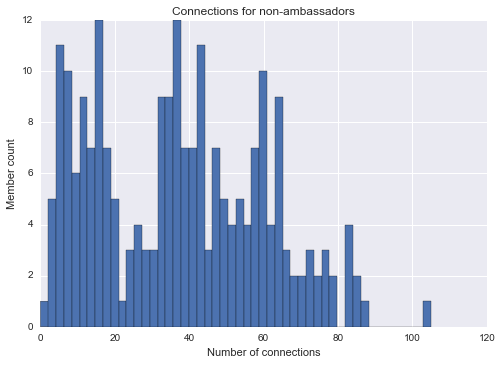

In [13]:
ssp.plot_members_degree(
    g,
    folder+'/non_ambassador_degrees.png',
    limit='non_ambassadors',
    title='Connections for non-ambassadors')

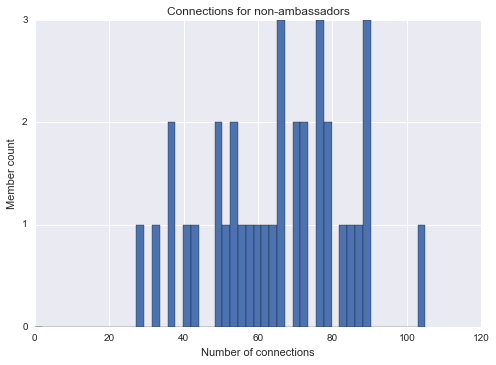

In [14]:
ssp.plot_members_degree(
    g,
    folder+'/non_ambassador_degrees.png',
    limit='ambassadors_all_times',
    title='Connections for non-ambassadors')

It is pretty apparent that the ambassadors tent to have more connections, but we can also see that some of the non-ambassadors have just as many connections as the ambassadors by random change!

** Long term trends**

Let's see how the number of members change a longer stretch of time, say 20 years, after we let the ambassadors change and after the introduction of global events. The members should have more connections now, so be less likely to leave. 

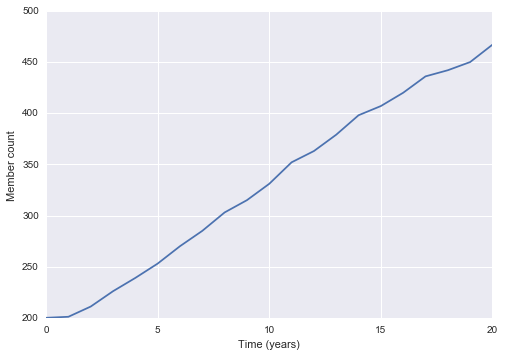

In [15]:
name = 'members_over_time'

TN_configs.update({
    'simulation_years': 20
})
g, g_states = run_simulation(TN_configs)
ssp.plot_members_over_time(g_states, filename=folder+'/'+name+'.pdf')

Yep, that made a big difference. The network only looses a few members in the bigginning, and will then steadily increase it's member count. 

We can see that the members are getting older and older as times goes on. 

** Maximum age of members **

What happens happens to the age distribution as time goes on.

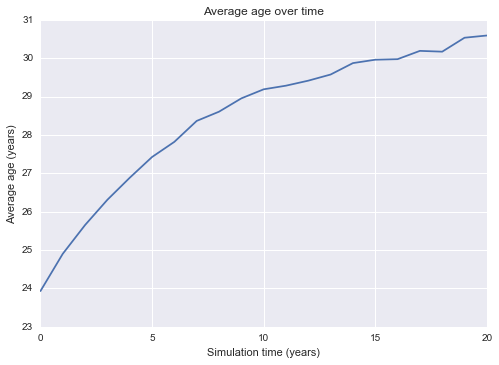

In [16]:
name = 'avg_age_over_time'
ssp.plot_avg_age_over_time(
        g_states,
        filename=folder+'/.pdf')

However, ThousandNetwork was meant to be for young people, so maybe this is not ideal. What happens if we start kicking members out when they turn say 35 year old.

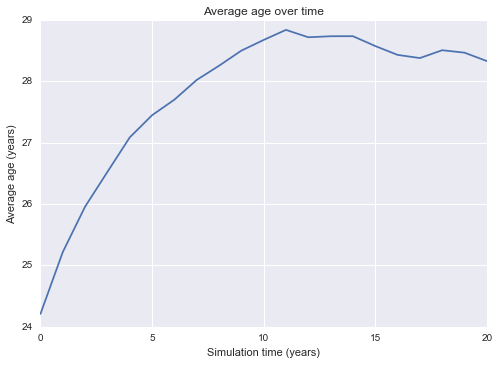

In [17]:
name = 'avg_age_over_time_max_35'

TN_configs.update({
    'max_age': 35,
})
g, g_states = run_simulation(TN_configs)

ssp.plot_avg_age_over_time(
        g_states,
        filename=folder+'/.pdf')

This has the effect of flattening out the member count after about 10 years. So after 10 years the number of new members is about equal to the number of members who leave the network. 

Let's see how the age distribution changes over time (scroll down) 

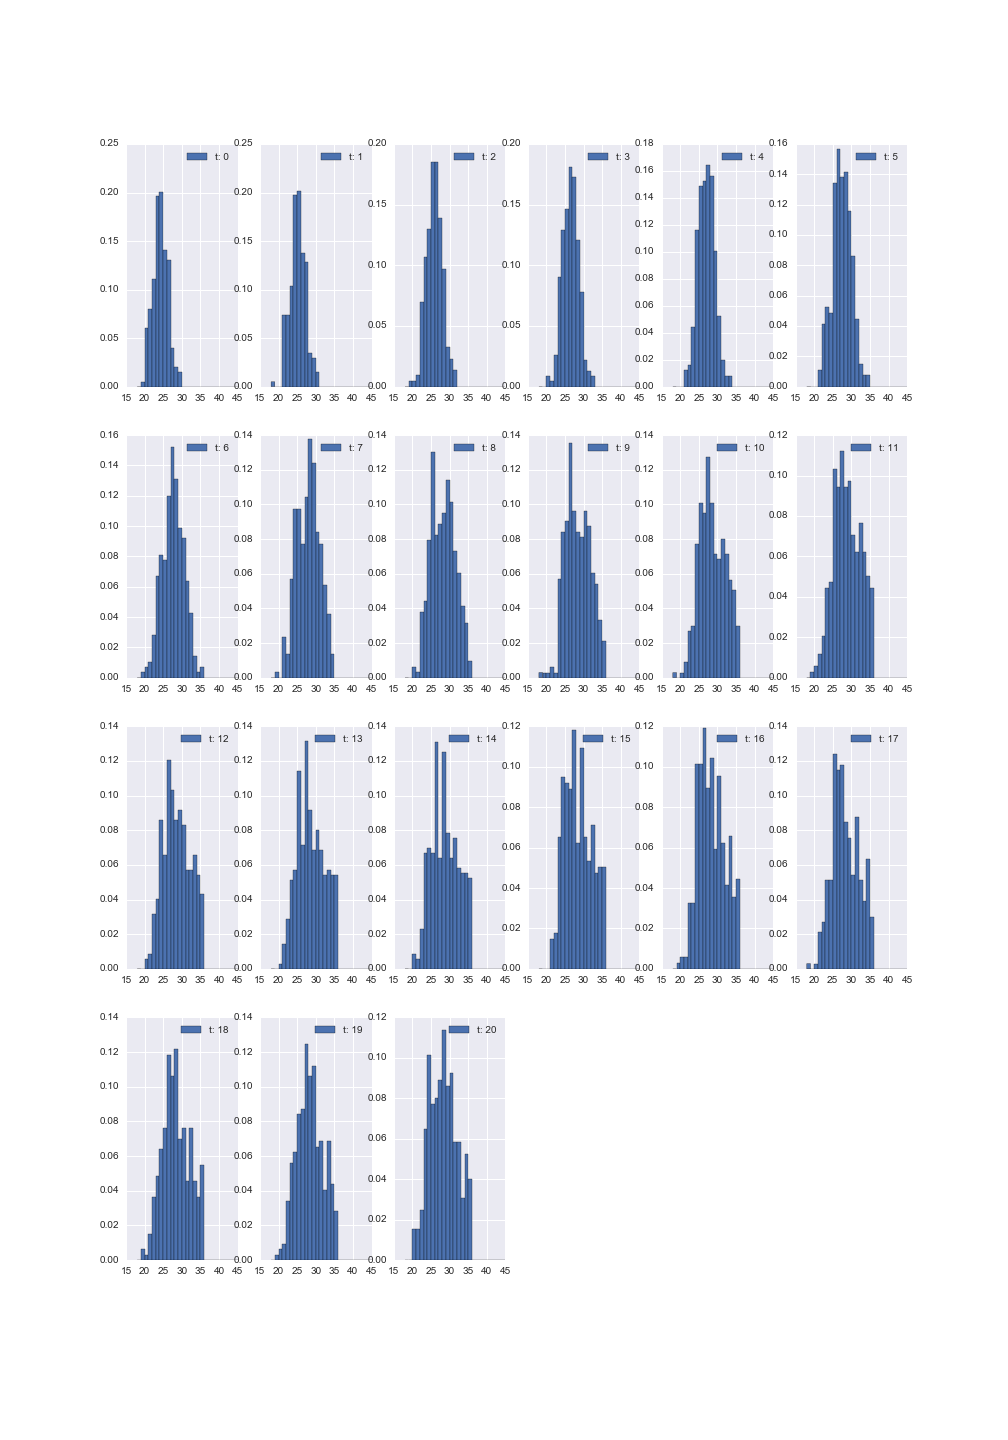

In [18]:
name = 'Age_distribution_over_time'
ssp.plot_age_distribution_over_time(g_states, filename=folder+'/'+name+'.png')
Image(filename=folder+'/'+name+'.png')

We see a sharp decline at 35 years as expected, and that shape of the distribution remains pretty constant but with a shift to the right. 

Let's try to compare the member count depending on the members uptake rate - say between 50% and 25%

In [19]:
name = 'higher _time_max_35'

TN_configs.update({
    'new_member_ratio': 0.5,                  
})
g_1, g_states_1 = run_simulation(TN_configs)

TN_configs.update({
    'new_member_ratio': 0.25,                  
})

g, g_states = run_simulation(TN_configs)


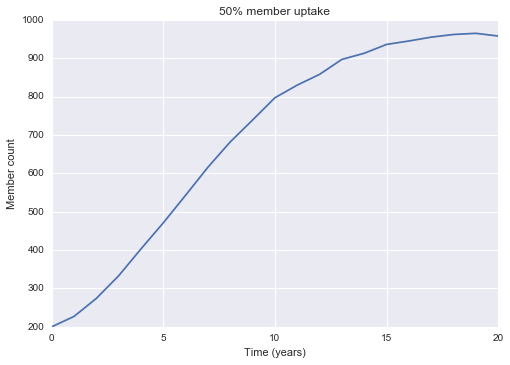

In [20]:
ssp.plot_members_over_time(
    g_states_1, 
    filename=folder+'/member_count_50_percent_uptake.pdf',
    title='50% member uptake',)

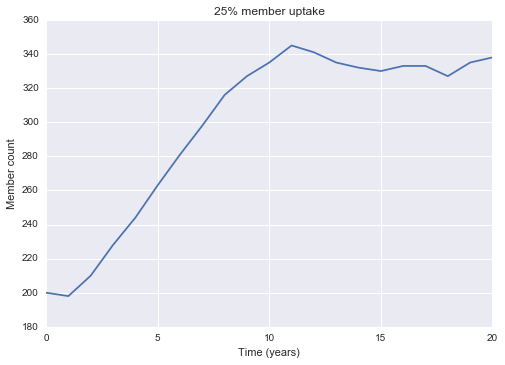

In [21]:
ssp.plot_members_over_time(
    g_states, 
    filename=folder+'/member_count_25_percent_uptake.pdf',
    title='25% member uptake')

Not surprisingly, we get a much higher member count when increase the member uptake to 50%. The member count still levels out at some point though, but now at around 1000 members for the 10 cities. As a results the number of connections each member has will drastically go down, as we see here

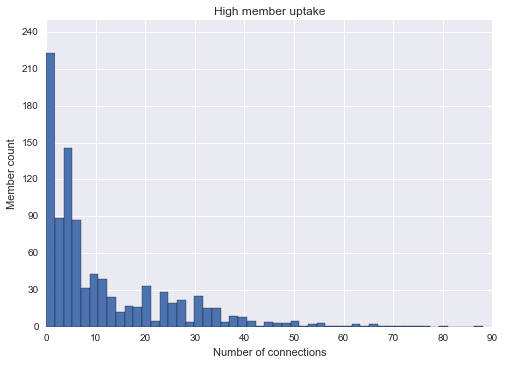

In [22]:
ssp.plot_members_degree(
    g_1, folder+'/all_member_degrees_high_uptake.png', 
    title='High member uptake')

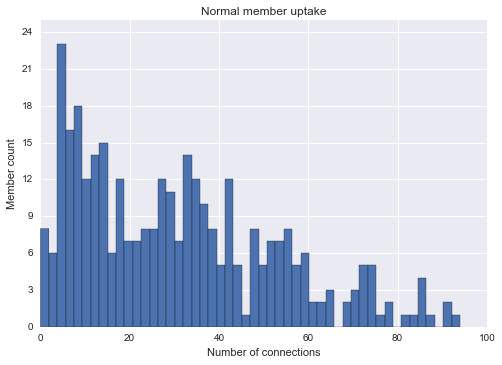

In [23]:
ssp.plot_members_degree(
    g, folder+'/all_member_degrees_normal_uptake.png', 
    title='Normal member uptake')

The ambassadors might start to make more/bigger local events if you had more hub members though, which could counter this effect.

** Connectivity ** 

The last question that I will explore here is how connected the network is. This could be measured by how many steps you usually have to go through to reach another member. I'll here ignore the members who haven't yet made friends. Similar to the small world problem (http://snap.stanford.edu/class/cs224w-readings/milgram67smallworld.pdf).

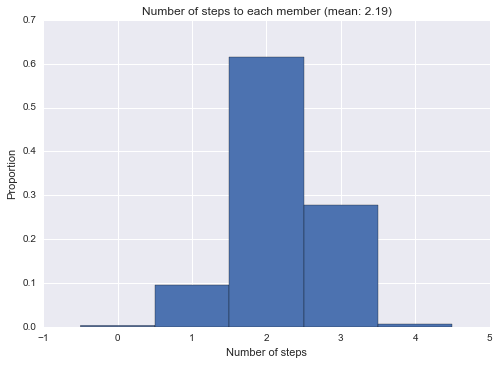

In [24]:
name = 'connection_distance_between_members'
ssp.hist_shortest_path(g, folder+'/'+name+'.png')

On average there is about 2 connections between the members, but we have a tail where some members need to go though 4 people to be connected. 

** Full network **

Let's now try to put everything together and make a simulation with all the cities! For this, I have made a couple of adjustments more. Increased city hopping to 10%, the local event participants, and the average mem

In [26]:
name = 'Full Thousand network simulation'

TN_configs_full ={
    'verbose': 1,
    
    # Initializing 
    'hub_cities': data['ThousandNetwork_cities'],
    'hub_starting_members_avg': 25,
    'mean_starting_age': 24,
    'starting_age_std': 2,
    
    # Local events
    'yearly_local_events': 6,
    'local_event_participants': 15,
    'local_event_avg_new_link_per_participant': 5,

    # Global retreat        
    'yearly_global_retreats': 1,
    'global_retreat_goers': 300,
    'global_retreat_link_multiplier': 20,

    # city hopping
    'city_hopping_propability': 0.10,  # 10% chance of changing city    
        
    # New members
    'new_member_ratio': 0.25,                  
    
    # Change ambassadors    
    'promote_new_ambassador_yearly': True,
    
    # churn
    'churn_no_degree_rate': 0.8,
    'base_churn': 0.02, 
    'max_age': 35,
    
    # overall
    'degree_count_power': 0.5, 
    'simulation_years': 20,
    }
g_states = run_simulation_cached(
        TN_configs_full,
        'full_thousand_network',
        redo=True,
        simu_folder='')

g = g_states[-1]

Initializing network
year 0 members 925 avg_age: 24.0
year 1 members 933 avg_age: 25.1
year 2 members 988 avg_age: 25.9
year 3 members 1058 avg_age: 26.6
year 4 members 1143 avg_age: 27.0
year 5 members 1232 avg_age: 27.5
year 6 members 1336 avg_age: 27.8
year 7 members 1430 avg_age: 28.1
year 8 members 1527 avg_age: 28.4
year 9 members 1610 avg_age: 28.6
year 10 members 1676 avg_age: 28.8
year 11 members 1705 avg_age: 28.6
year 12 members 1715 avg_age: 28.6
year 13 members 1722 avg_age: 28.5
year 14 members 1731 avg_age: 28.4
year 15 members 1752 avg_age: 28.4
year 16 members 1759 avg_age: 28.5
year 17 members 1772 avg_age: 28.5
year 18 members 1772 avg_age: 28.4
year 19 members 1788 avg_age: 28.5
end     members 1814 avg_age: 28.5
 -- stopping simulations -- 


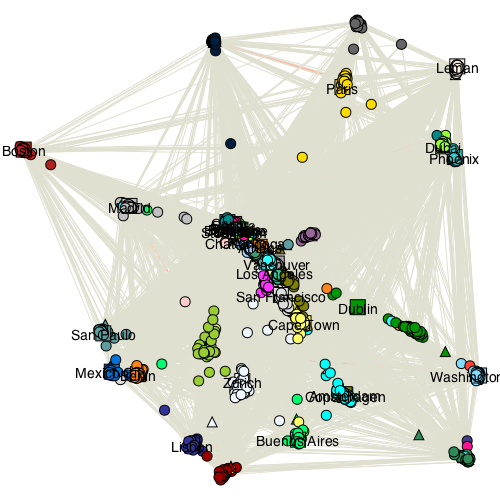

In [27]:
ssp.plot_graph(
    g, folder+'/'+name+'.png', 
    delete_zero_connections=1)
Image(folder+'/'+name+'.png')

With members from 30 cities, there are now so many members and connections that it is hard to really see that much. 

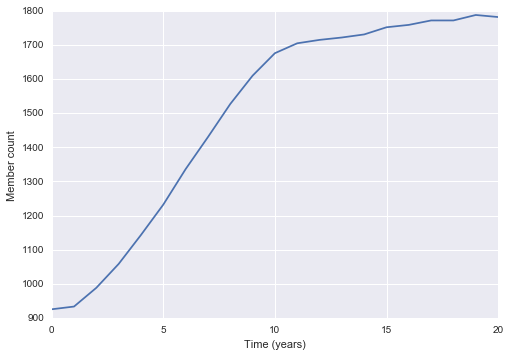

In [29]:
name = 'full_simulation_members'
ssp.plot_members_over_time(g_states, filename=folder+'/'+name+'.pdf')

The number of members goes up to a couple of thousand members, and then levels off.

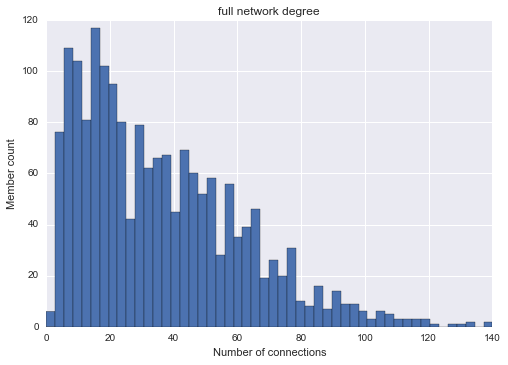

In [30]:
ssp.plot_members_degree(g, folder+'/ambassador_degrees_full.png', title='full network degree')

With a very wide distribute on the number of connections

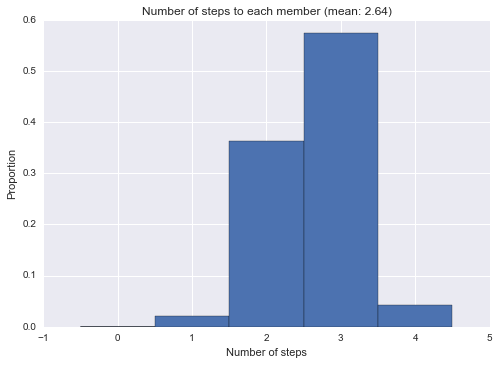

In [31]:
name = 'connection_distance_between_members_full'
ssp.hist_shortest_path(g, folder+'/'+name+'.png')

We can see that the average number of connections between the members has gone up by a half. All members can however still be reached within 4 connections. 

** End notes**

What did we learn? What might have been surprising? 

 - That the age of a network will keep increasing if there not a policy like a maximum age.
 - That each member's number of connections to other members can vary quite significantly.
 - That both city hopping and global events are important for making a truly international network.
 - That it is likely that all members can reach each other following less than 3 connections.

There are so many more things that I could look into, and it should be possible to make the simulation a lot more realistic. Here are some things that I do not include, but that could be interesting to have in the model.

 - Starting new city hubs. All hubs are set from the beginning, which is not realistic. Closing hubs should also be an option. It would be quite interesting if the simulation could reproduce the evolution of the real network from it's beginning in 2009.
 - More ways members can interact depending on connection strenghts. In social network analysis the will members with strong bonds introduce each others friends to make a more closely connected network, which is called triage. This could help making the network look more like a real social network with strongly bonded groups within and between hubs.
 - Interactive simulation with animaiton! It would be cool if the graph simulation was animated when it run, and where the user could interact and change properties when it was running. 
 - Interaction with the outside world. The number of members within each city hub could be dependent on popularity of the cities, GDP, or other things. The simulation could use future projections from e.g. think tanks as inputs.


I have made all the code for the simulation [avaliable on github](https://github.com/keldLundgaard/ThousandNetwork_simulation). 

In case you missed it in the beginning:

I have also made [a live instance of this document available here](https://ec2-54-67-55-17.us-west-1.compute.amazonaws.com:8889/notebooks/Thousand%20Network%20simulation.ipynb)! 
Password: thousandnetwork. Here you to see what happen if you change any of the options and run the simulation. Beware the last simulation takes quite a long time to run! [see this guide for how to use a jupyter document like this](http://nbviewer.jupyter.org/github/ipython/ipython/blob/1.x/examples/notebooks/Part%201%20-%20Running%20Code.ipynb).




That's it: Hope to give you a hug at one of the coming thousands events

Keld 

========

PS:

Please let me know if you have any ideas or want to give some feedback. 
You can reach me on keld.lundgaard@gmail.com

